In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns
sns.set()
from tqdm import tqdm

import itertools
from scipy import stats
from math import log10, floor

import phenalyze as ph

# Lectura de datos

In [38]:
k_r_list = np.linspace(1,3,10)
b_list = np.linspace(1,3,10)
h_list = np.linspace(1,4,10)

### Ruido Intrínseco

In [39]:
datalist = []

for h_i in h_list:
    for k_r in k_r_list:
        for b_i in b_list:
            df = pd.read_csv(f"Data_RangoParcial/Represores/RuidoIntrinseco/h{h_i:.1f}_kr{k_r:.1f}_b{b_i:.1f}.csv", header=0, index_col=0)
            df.insert(0, "h", [h_i, h_i])
            df.insert(1, "kr", [k_r, k_r])
            df.insert(2, "Beta", [b_i, b_i])
            datalist.append(df)

tint_data = pd.concat(datalist)
tint_data.columns = ['h', 'kr', 'Beta', 'RNA 1', 'Protein 1', 'RNA 2', 'Protein 2', 'RNA 3', 'Protein 3']
display(tint_data)

,h,kr,Beta,RNA 1,Protein 1,RNA 2,Protein 2,RNA 3,Protein 3
Mean,1.0,1.0,1.000000,4.372816,4228.092473,2.469471,2400.064389,7.655224,7396.533549
CV2,1.0,1.0,1.000000,0.229086,0.031195,0.409362,0.057629,0.133535,0.020640
Mean,1.0,1.0,1.222222,4.366858,4228.781247,3.044760,2958.882409,7.118862,6884.449982
CV2,1.0,1.0,1.222222,0.229043,0.031102,0.334634,0.047856,0.145640,0.022373
Mean,1.0,1.0,1.444444,4.352349,4215.489873,3.590444,3490.727116,6.706598,6481.863089
...,...,...,...,...,...,...,...,...,...
CV2,4.0,3.0,2.555556,0.076356,0.010413,2.520399,0.387806,0.091695,0.012596
Mean,4.0,3.0,2.777778,13.097633,12689.260744,0.454616,466.000407,10.897329,10516.920244
CV2,4.0,3.0,2.777778,0.076452,0.010549,2.378472,0.368614,0.091610,0.012654
Mean,4.0,3.0,3.000000,13.079189,12657.302344,0.500758,512.269269,10.918727,10542.308976


### Ruido neto

In [40]:
datalist = []

for h_i in h_list:
    for k_r in k_r_list:
        for b_i in b_list:
            df = pd.read_csv(f"Data_RangoParcial/Represores/RuidoNeto/h{h_i:.1f}_kr{k_r:.1f}_b{b_i:.1f}.csv", header=0, index_col=0)
            df = df.T
            df.insert(0, "h", [h_i, h_i])
            df.insert(1, "kr", [k_r, k_r])
            df.insert(2, "Beta", [b_i, b_i])
            datalist.append(df)

tnet_data = pd.concat(datalist)
tnet_data.columns = ['h', 'kr', 'Beta', 'RNA 1', 'Protein 1', 'RNA 2', 'Protein 2', 'RNA 3', 'Protein 3']
display(tnet_data)

,h,kr,Beta,RNA 1,Protein 1,RNA 2,Protein 2,RNA 3,Protein 3
Mean,1.0,1.0,1.000000,4.362859,4227.429664,2.469888,2391.909663,7.600530,7373.147297
CV2,1.0,1.0,1.000000,0.283414,0.061671,0.447189,0.074917,0.180060,0.042833
Mean,1.0,1.0,1.222222,4.374595,4237.877359,3.017536,2923.282734,7.136320,6914.228663
CV2,1.0,1.0,1.222222,0.281887,0.060959,0.373714,0.064778,0.186623,0.043297
Mean,1.0,1.0,1.444444,4.358446,4225.289446,3.572454,3463.478008,6.696415,6489.818258
...,...,...,...,...,...,...,...,...,...
CV2,4.0,3.0,2.555556,0.130003,0.040449,2.599977,0.632327,0.145398,0.042366
Mean,4.0,3.0,2.777778,13.109595,12704.148052,0.540112,513.109687,10.927001,10587.858459
CV2,4.0,3.0,2.777778,0.129930,0.040564,2.437516,0.615039,0.145255,0.042648
Mean,4.0,3.0,3.000000,13.092455,12684.827751,0.582156,552.847485,10.878368,10549.883732


### Organización de los datos

In [41]:
tres_int = tint_data.loc["CV2"]
tres_net = tnet_data.loc["CV2"]

tres_efc = tres_net.copy()
tres_efc["RNA 3"] = tres_net["RNA 3"] - tres_int["RNA 3"]
tres_efc["Protein 3"] = tres_net["Protein 3"] - tres_int["Protein 3"]

# Seed Tuning

In [42]:
def round_to_n(x, n):
  return round(x, -(int(floor(log10(abs(x))))-n+1))

round_to_n = np.vectorize(round_to_n)

In [43]:
def seed_explorer(data, h_list, model, params_space, bounds):
    all_params = []
    all_errs = []
    all_R2 = []

    all_seeds = list(itertools.product(*params_space))
    for seed in tqdm(all_seeds):
        try:
            params, err, Rsquared = ph.compute_3dfit(data, h_list, model, seed=10*[seed], lims=10*[bounds], max_ef=100000000)
            all_params.append(params)
            all_errs.append(err)
            all_R2.append(Rsquared)
        except:
            pass

    return np.array(all_seeds), np.array(all_params), np.array(all_errs), np.array(all_R2)



def seed_estimator(seeds, params, errs, R2s, n=None, R2_precision=6, params_SF=4):
    R2s = R2s.mean(axis=1)

    ii_kill = np.argwhere(np.isnan(R2s))
    print(f"{len(ii_kill)} de {len(R2s)} semillas resultaron en NaNs")

    R2s = np.delete(R2s, ii_kill, axis=0)
    seeds = np.delete(seeds, ii_kill, axis=0)
    params = np.delete(params, ii_kill, axis=0)
    errs = np.delete(errs, ii_kill, axis=0)

    ii_max = np.argsort(R2s, axis=0)[::-1]
    
    R2max = np.sort(R2s,axis=0)[::-1][0]
    i = 0
    R2i = np.sort(R2s,axis=0)[::-1][i]
    params = params.mean(axis=1)
    while R2i.round(R2_precision)==R2max.round(R2_precision) and np.all(round_to_n(params[ii_max[i],:], params_SF)==round_to_n(params[ii_max[0],:], params_SF)):
        R2i = np.sort(R2s,axis=0)[::-1][i]
        i+=1
    n_sug = i
    print(f"n sugerido: {n_sug} de {len(R2s)}")

    if n is None:
        n = n_sug

    best_seeds = seeds[ii_max[:n]]
    errs = errs.mean(axis=1)
    best_seeds_err = errs[ii_max[:n]]

    if np.isinf(best_seeds_err).any():
        print(f"Hay {np.isinf(best_seeds_err).sum()} errores infinitos")
    else:
        print(f"No hay errores infinitos en los {n} mejores")
        
    tuned_seed, _ = stats.mode(best_seeds, axis=0, keepdims=False)

    return tuned_seed

In [44]:
def PlotOptmizedParams(ParamsTensor, R2List, shape, labels, title, fig_size=(12,8)):
    fig = plt.figure(figsize=fig_size)
    export_data = []
    for i in range(np.shape(ParamsTensor)[1]):
        ax = fig.add_subplot(shape[0],shape[1],i+1)
        ax.plot(ParamsTensor[:,i], marker='.')
        ax.set_ylabel(fr"Parámetro ${labels[i]}$ del modelo")
        ax.set_xlabel(r"Coeficiente de Hill ($h$)")
        export_data.append([ParamsTensor[:,i], ax.get_ylim()])
    ax = fig.add_subplot(shape[0],shape[1],i+2)
    ax.plot(R2List, marker=".")
    ax.set_ylabel(r"$R^2$")
    ax.set_xlabel(r"Coeficiente de Hill ($h$)")
    ax.set_ylim(0,1.1)

    print(export_data)
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig("GraficasParaGuardar/MalMuestreo/"+title.replace(' ','').replace('$','').replace('\e','e').replace('\n','')+".png")

# Análisis

### Ruido intrínseco

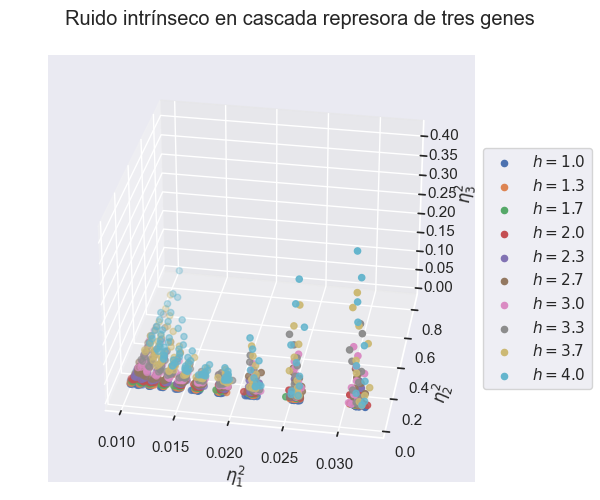

In [45]:
ph.plot_3ddata_all_h(tres_int, h_list, fig_size=(6,5), title="Ruido intrínseco en cascada represora de tres genes", view_init=[30,-80,0])
plt.savefig("GraficasDocumento/DataIntrinsecoTresRepresores.png")

In [46]:
def model(data, A, b, C, d, K):
    x, y = data
    return A*np.exp(-b*x) + C*np.exp(-d*y) + K


n_params = 5

space_int = n_params*[[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]]

bounds_int = ((n_params-1)*[-np.inf]+[0.0], n_params*[np.inf])

# seeds_int, all_params_int, all_errs_int, all_R2_int = seed_explorer(tres_int, h_list, model, space_int, bounds_int)
# np.savez("SeedExplr2.0_IntrinsecoTresRepresores", seeds=seeds_int, params=all_params_int, errs=all_errs_int, R2=all_R2_int)

In [47]:
exploration_data = np.load("SeedExplr2.0_IntrinsecoTresRepresores.npz")
seeds_int, all_params_int, all_errs_int, all_R2_int = exploration_data["seeds"], exploration_data["params"], exploration_data["errs"], exploration_data["R2"]

In [48]:
def_seed_int = seed_estimator(seeds_int, all_params_int, all_errs_int, all_R2_int, params_SF=3)
def_seed_int

0 de 16807 semillas resultaron en NaNs
n sugerido: 2 de 16807
No hay errores infinitos en los 2 mejores


array([0.001, 0.01 , 0.01 , 0.1  , 0.001])

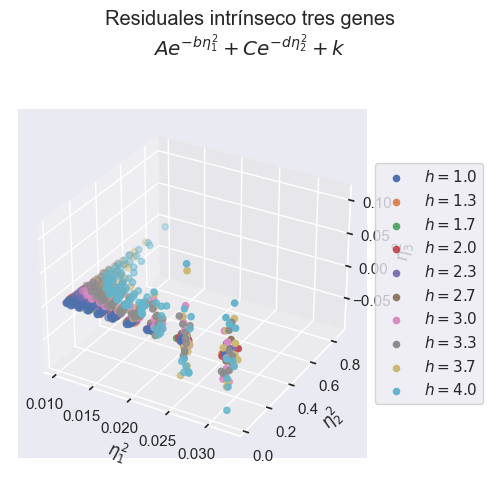

In [49]:
params, err, Rsquared = ph.compute_3dfit(tres_int, h_list, model, seed=10*[def_seed_int], lims=10*[bounds_int], max_ef=1000000000)
# print(Rsquared)

ph.plot_3dresiduals_all_h(tres_int, h_list, model, params, title="Residuales intrínseco tres genes"+"\n"+r"$A e^{-b \eta_1^2} + C e^{-d \eta_2^2} + k$", fig_size=(5,5))
# print(params)

TresIntParams = np.array(params)
TresIntR2 = np.array(Rsquared)

In [50]:
# ph.plot_3dfit_each_h(tres_int, h_list, model, params, err, fig_size=(15,8))

[[array([-2.59112800e+00, -1.14681132e-04, -4.18037141e-05, -2.00456774e-04,
       -2.25068710e-04, -3.88669143e-04,  2.80916904e-02, -1.39279024e-03,
       -1.30604700e-03, -1.14973197e-03]), (-2.7220889887853024, 0.159052675093255)], [array([ 888.37835769,  -75.42647563, -148.33409388, -129.51929862,
       -153.09141093, -157.37588939,   58.89217976, -150.26689241,
       -162.69949934, -178.90222052]), (-232.26624942930093, 941.742386596576)], [array([0.03985879, 0.06853399, 0.12120551, 0.2104408 , 0.37190925,
       0.55908729, 0.44311023, 0.98028801, 1.25010493, 1.61906247]), (-0.03910139422093759, 1.6980226524325546)], [array([47.51654024, 45.75236385, 46.48455224, 47.16626991, 47.73165417,
       44.31667141, 39.08976463, 35.84789446, 32.84060522, 30.71359138]), (29.862688242598786, 48.58255731209481)], [array([1.83976505e-02, 1.66163207e-02, 1.49471673e-02, 1.46619914e-02,
       1.44751480e-02, 1.50171241e-02, 2.11700720e-20, 2.17935124e-02,
       2.30487407e-02, 2.5347400

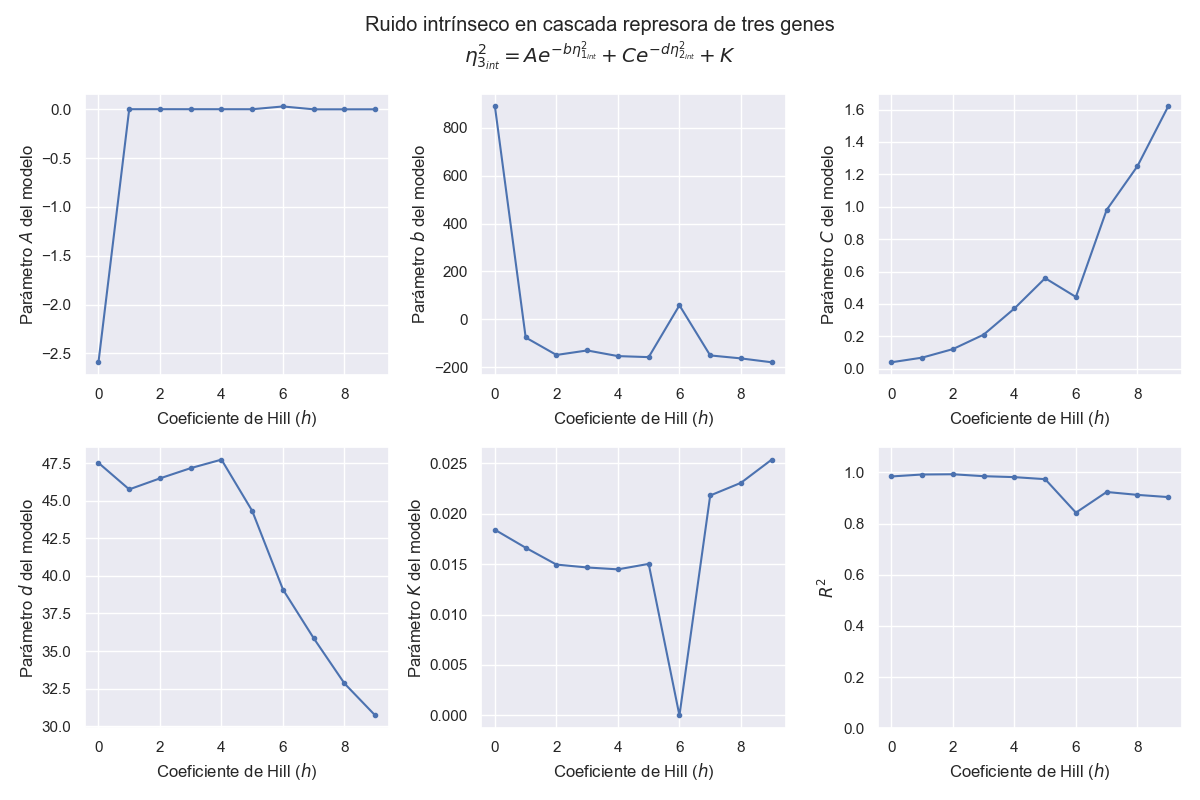

In [51]:
labels = ["A", "b", "C", "d", "K"]
PlotOptmizedParams(TresIntParams, TresIntR2, (2,3), labels, "Ruido intrínseco en cascada represora de tres genes"+"\n"+r"$\eta_{3_{int}}^2 = Ae^{-b\eta_{1_{int}}^2}+Ce^{-d\eta_{2_{int}}^2}+K$")

### Ruido global efectivo

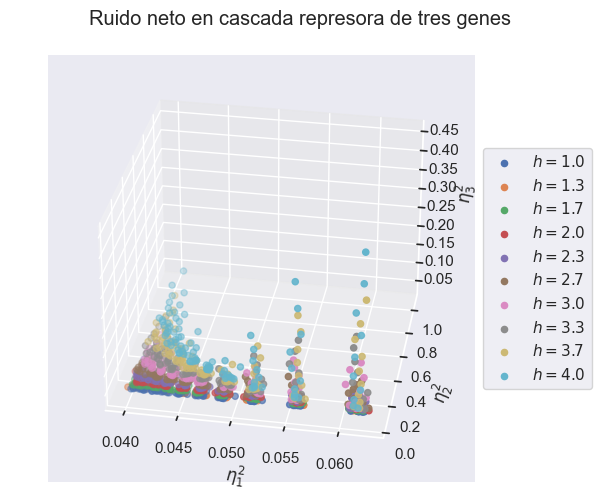

In [54]:
ph.plot_3ddata_all_h(tres_net, h_list, fig_size=(6,5), title="Ruido neto en cascada represora de tres genes", view_init=[30,-80,0])
plt.savefig("GraficasDocumento/DataNetoTresRepresores.png")

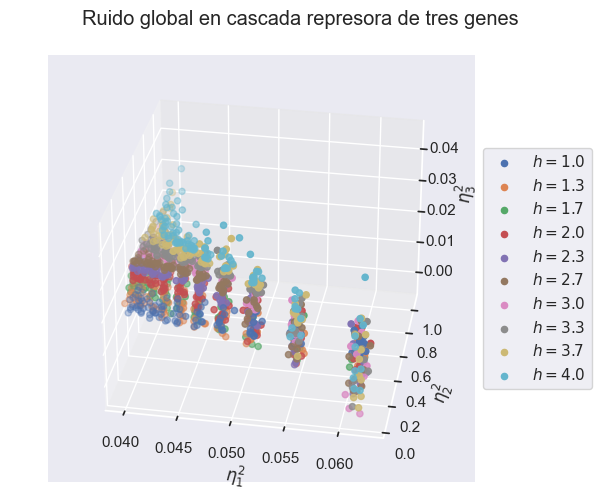

In [55]:
ph.plot_3ddata_all_h(tres_efc, h_list, fig_size=(6,5), title="Ruido global en cascada represora de tres genes", view_init=[30,-80,0])
plt.savefig("GraficasDocumento/DataGlobalTresRepresores.png")

In [56]:
def model(data, A, b, C, d, K):
    x, y = data
    return A*(x**(-b)) + C*(y**(-d)) + K

n_params = 5

space_net = n_params*[[0.01, 0.1, 10.0, 100.0]]

bounds_net = ((n_params-1)*[-np.inf]+[0.0], n_params*[np.inf])

# seeds_net, all_params_net, all_errs_net, all_R2_net = seed_explorer(tres_efc, h_list, model, space_net, bounds_net)
# np.savez("SeedExplr2.0_GlobalTresRepresores", seeds=seeds_net, params=all_params_net, errs=all_errs_net, R2=all_R2_net)

In [57]:
exploration_data = np.load("SeedExplr2.0_GlobalTresRepresores.npz")
seeds_net, all_params_net, all_errs_net, all_R2_net = exploration_data["seeds"], exploration_data["params"], exploration_data["errs"], exploration_data["R2"]

In [58]:
def_seed_net = seed_estimator(seeds_net, all_params_net, all_errs_net, all_R2_net, params_SF=3)
def_seed_net

0 de 1024 semillas resultaron en NaNs
n sugerido: 1 de 1024
No hay errores infinitos en los 1 mejores


array([10.  ,  0.01,  0.1 ,  0.1 ,  0.1 ])

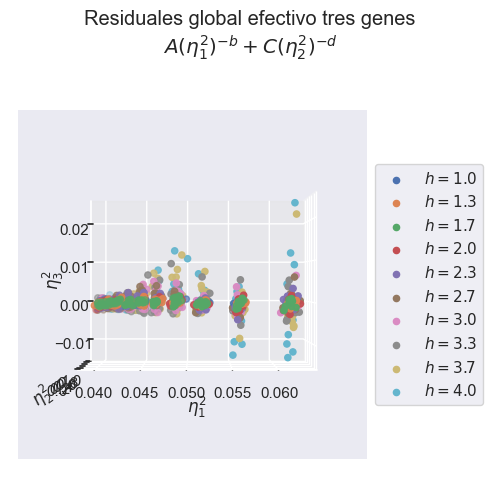

In [59]:
params, err, Rsquared = ph.compute_3dfit(tres_efc, h_list, model, seed=10*[def_seed_net], lims=10*[bounds_net], max_ef=100000000)
# print(Rsquared)

ph.plot_3dresiduals_all_h(tres_efc, h_list, model, params, title="Residuales global efectivo tres genes"+"\n"+r"$A(\eta_1^2)^{-b}+C(\eta_2^2)^{-d}$", fig_size=(5,5), view_init=(0,-90,0))
# print(params)

TresGlobParams = np.array(params)
TresGlobR2 = np.array(Rsquared)

In [60]:
# ph.plot_3dfit_each_h(tres_efc, h_list, model, params, err, fig_size=(15,8), view_init=[15,45,0])

[[array([ 1.37505986e-02,  1.07289444e-02,  6.92827472e-03,  7.24062988e-03,
       -4.04176271e+02, -3.39150125e+05, -3.86135268e-20, -1.09346855e-18,
        1.87967078e-01, -2.15884941e+06]), (-2266791.8860394955, 107942.66768167652)], [array([ 0.21868515,  0.31430544,  0.46319062,  0.45485642, -3.93489161,
       -6.49703665, 12.13146257, 11.21971783, -0.56148552, -6.45532882]), (-7.4284616098707374, 13.062887532990866)], [array([-1.50748943e-04, -6.65474540e-05, -1.73434692e-05, -3.73507270e-06,
       -2.83857083e-06, -5.26102883e-06, -9.13010494e-06, -2.34841188e-05,
       -6.77910132e-05,  3.10420329e-02]), (-0.0017103880336266993, 0.03260167196391161)], [array([1.27557488, 1.6148124 , 2.08781697, 2.63320737, 2.78067522,
       2.65100932, 2.58916552, 2.30176062, 2.01982924, 0.1444005 ]), (0.012586764180004956, 2.9124889536620233)], [array([2.17702848e-10, 6.10214860e-19, 2.81115111e-16, 5.38395640e-13,
       3.28281127e-02, 3.21183080e-02, 3.33759695e-02, 3.44554290e-02,
   

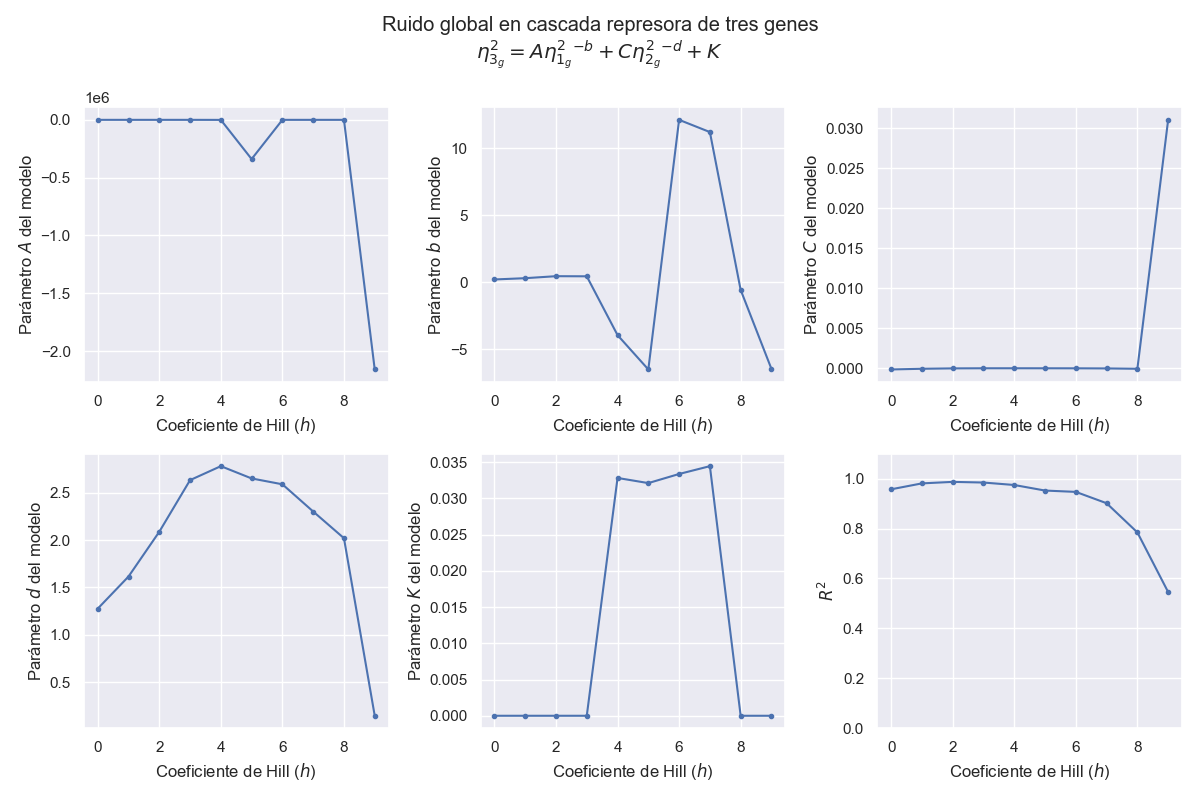

In [61]:
labels = ["A", "b", "C", "d", "K"]
PlotOptmizedParams(TresGlobParams, TresGlobR2, (2,3), labels, "Ruido global en cascada represora de tres genes"+"\n"+r"$\eta_{3_g}^2=A{\eta_{1_g}^2}^{-b}+C{\eta_{2_g}^2}^{-d}+K$")

# Import 

In [104]:
bootstrap_data = np.load("Bootstrap_IntrinsecoTresRepresores.npz")
ParamsTensorTresInt, ErrTensorTresInt, R2TensorTresInt = bootstrap_data["params"], bootstrap_data["errs"], bootstrap_data["R2"]

bootstrap_data = np.load("Bootstrap_GlobalTresRepresores.npz")
ParamsTensorTresEfc, ErrTensorTresEfc, R2TensorTresEfc = bootstrap_data["params"], bootstrap_data["errs"], bootstrap_data["R2"]

In [105]:
def define_lims(SimpleTensor, ParamsTensor):
    lims = []
    fig = plt.figure()
    for i in range(np.shape(SimpleTensor)[1]):
        ax1 = fig.add_subplot(121)
        ax1.plot(SimpleTensor[:,i], marker='.')

        ax2 = fig.add_subplot(122)
        ax2.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i] for j in range(len(h_list))]))

        lims.append((min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1])))
    plt.close()
    return lims


def weited_mean(x,σ2):
    w = 1/(σ2+1)
    sum_mean = np.sum(w*x)
    sum_var = np.sum(w)
    return [sum_mean/sum_var, 1/sum_var]

In [106]:
tup1 = [0,0,0,1,1]
tup2 = [0,2,4,1,3]

def plot_bootstrap(SimpleTensor, ParamsTensor, ErrTensor, labels, fig_size=(12,8), title="Figura sin título"):
    lims = define_lims(SimpleTensor, ParamsTensor)
    fig = plt.figure(figsize=fig_size)
    for i_plot in range(len(labels)):
        means_list = []
        stds_list = []
    
        # ax = fig.add_subplot(1, len(labels), i_plot+1)
        ax = plt.subplot2grid((2,6), (tup1[i_plot],tup2[i_plot]), colspan=2)
        for i_h in range(len(h_list)):
            ii_ErrorFinito = np.isfinite(ErrTensor[i_h][:,i_plot])
            means, stds = weited_mean(ParamsTensor[i_h][:,i_plot][ii_ErrorFinito], ErrTensor[i_h][:,i_plot][ii_ErrorFinito])
            means_list.append(means)
            stds_list.append(1.96*stds)

        im = ax.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i_plot] for j in range(len(h_list))]), c=np.concatenate([1/ErrTensor[j][:,i_plot] for j in range(len(h_list))]), s=1, cmap="viridis_r")
        plt.colorbar(im, ax=ax, label="Peso")
        
        ax.errorbar(x=h_list, y=np.array(means_list), yerr=1.96*np.array(stds_list), ecolor='black', alpha=0.5, capsize=5, fmt=" ")


        ax.set_ylabel(fr"Parámetro ${labels[i_plot]}$ del modelo")#, fontsize=15)
        ax.set_xlabel(r"Coeficiente de Hill ($h$)")#, fontsize=15)
        ax.set_ylim(lims[i_plot])

        if i_plot==1:
            ax.set_title("Después del remuestreo")

    # plt.suptitle(title)#, fontsize=20)
    plt.tight_layout()
    name = title.split("\n")[0].replace(" ","")
    plt.savefig(f"GraficasParaGuardar/EfectoBootstrap/DESPUES{name}.png")


def plot_prebootstrap(SimpleTensor, ParamsTensor, ErrTensor, labels, fig_size=(12,8), title="Figura sin título"):
    lims = define_lims(SimpleTensor, ParamsTensor)
    fig = plt.figure(figsize=fig_size)
    for i in range(np.shape(SimpleTensor)[1]):
        # ax = fig.add_subplot(1, len(labels), i+1)
        ax = plt.subplot2grid((2,6), (tup1[i],tup2[i]), colspan=2)

        ax.plot(SimpleTensor[:,i], marker='.')

        ax.set_ylim(lims[i])
        ax.set_ylabel(fr"Parámetro ${labels[i]}$ del modelo")#, fontsize=15)
        ax.set_xlabel(r"Coeficiente de Hill ($h$)")#, fontsize=15)

        if i==1:
            ax.set_title("Antes del remuestreo")

    plt.suptitle(title)#, fontsize=20)
    plt.tight_layout()
    name = title.split("\n")[0].replace(" ","")
    plt.savefig(f"GraficasParaGuardar/EfectoBootstrap/ANTES_{name}.png")


C:\Users\aleja\AppData\Local\Temp\ipykernel_5968\623865020.py:19: RuntimeWarning: divide by zero encountered in divide
  im = ax.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i_plot] for j in range(len(h_list))]), c=np.concatenate([1/ErrTensor[j][:,i_plot] for j in range(len(h_list))]), s=1, cmap="viridis_r")


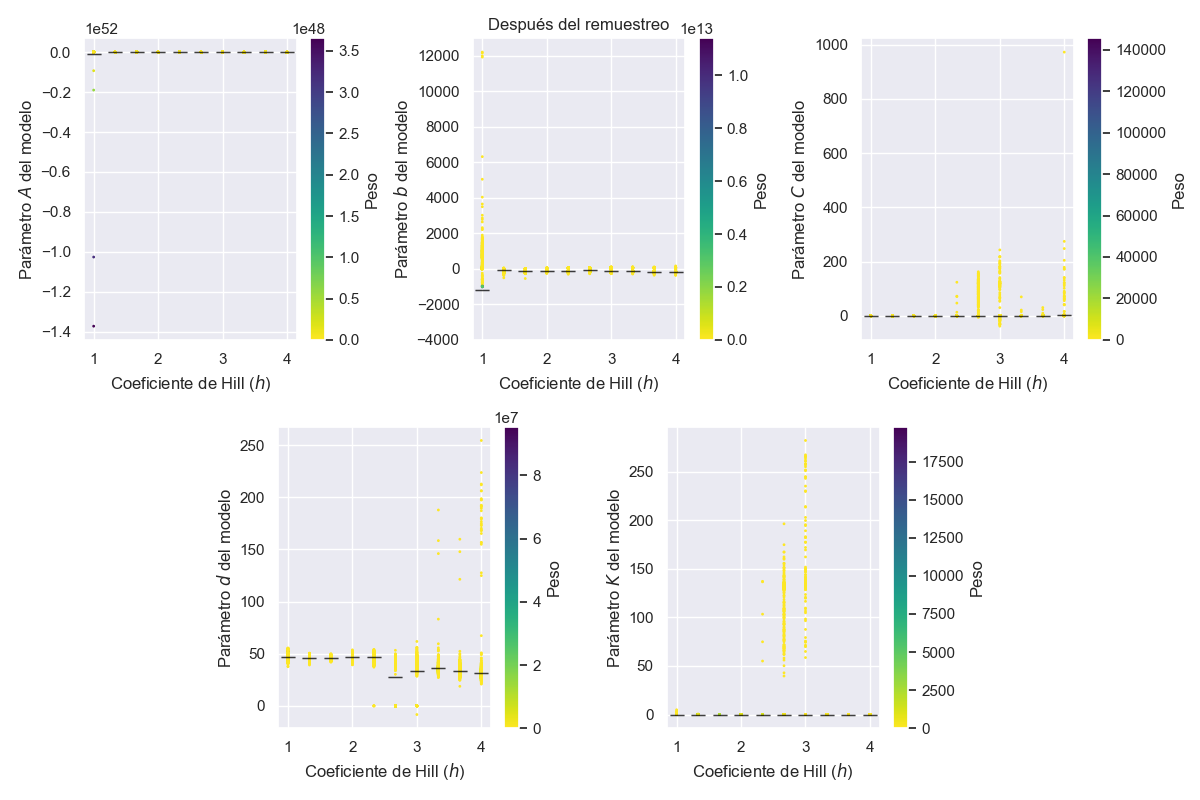

In [107]:
labels = ["A", "b", "C", "d", "K"]
plot_bootstrap(TresIntParams, ParamsTensorTresInt, ErrTensorTresInt, labels, title="Ruido intrínseco en cascada represora de tres genes"+"\n"+r"$\eta_{3_{int}}^2 = Ae^{-b\eta_{1_{int}}^2}+Ce^{-d\eta_{2_{int}}^2}+K$")

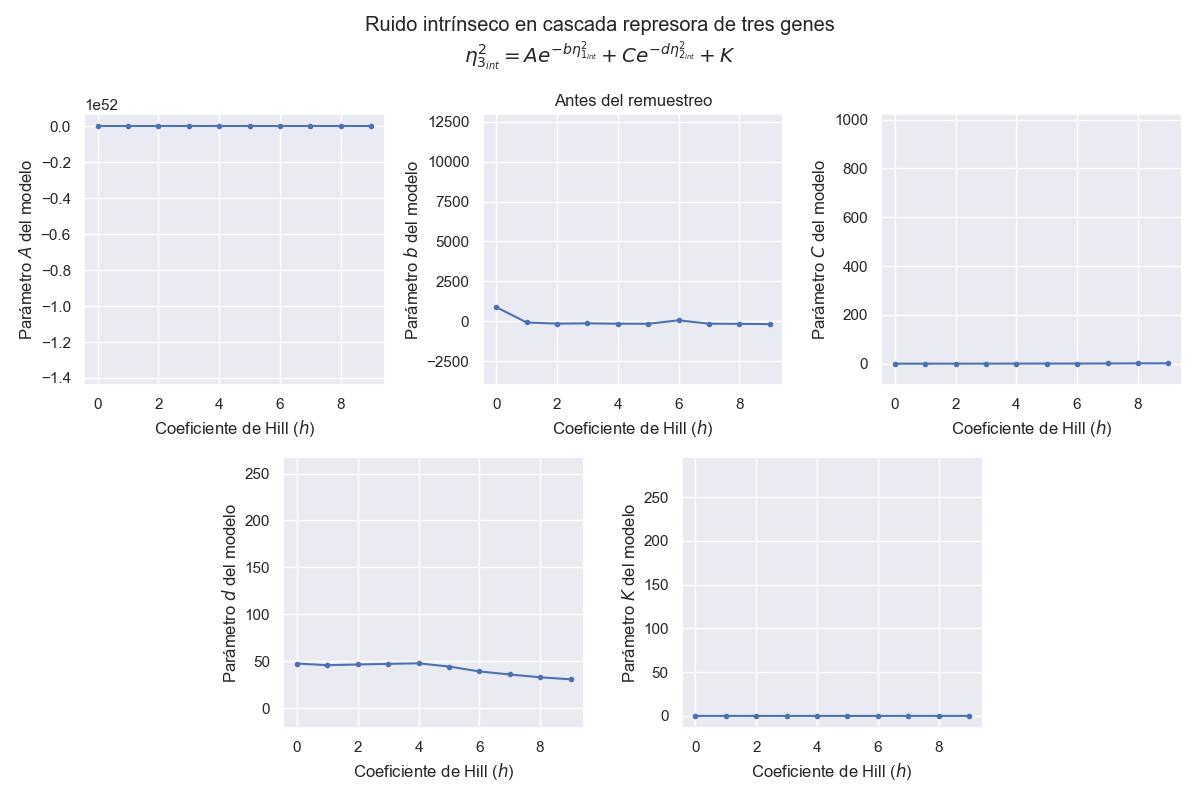

In [108]:
labels = ["A", "b", "C", "d", "K"]
plot_prebootstrap(TresIntParams, ParamsTensorTresInt, ErrTensorTresInt, labels, title="Ruido intrínseco en cascada represora de tres genes"+"\n"+r"$\eta_{3_{int}}^2 = Ae^{-b\eta_{1_{int}}^2}+Ce^{-d\eta_{2_{int}}^2}+K$")

C:\Users\aleja\AppData\Local\Temp\ipykernel_5968\623865020.py:19: RuntimeWarning: divide by zero encountered in divide
  im = ax.scatter(np.concatenate([np.shape(ParamsTensor[j])[0]*[h_list[j]] for j in range(len(h_list))]), np.concatenate([ParamsTensor[j][:,i_plot] for j in range(len(h_list))]), c=np.concatenate([1/ErrTensor[j][:,i_plot] for j in range(len(h_list))]), s=1, cmap="viridis_r")


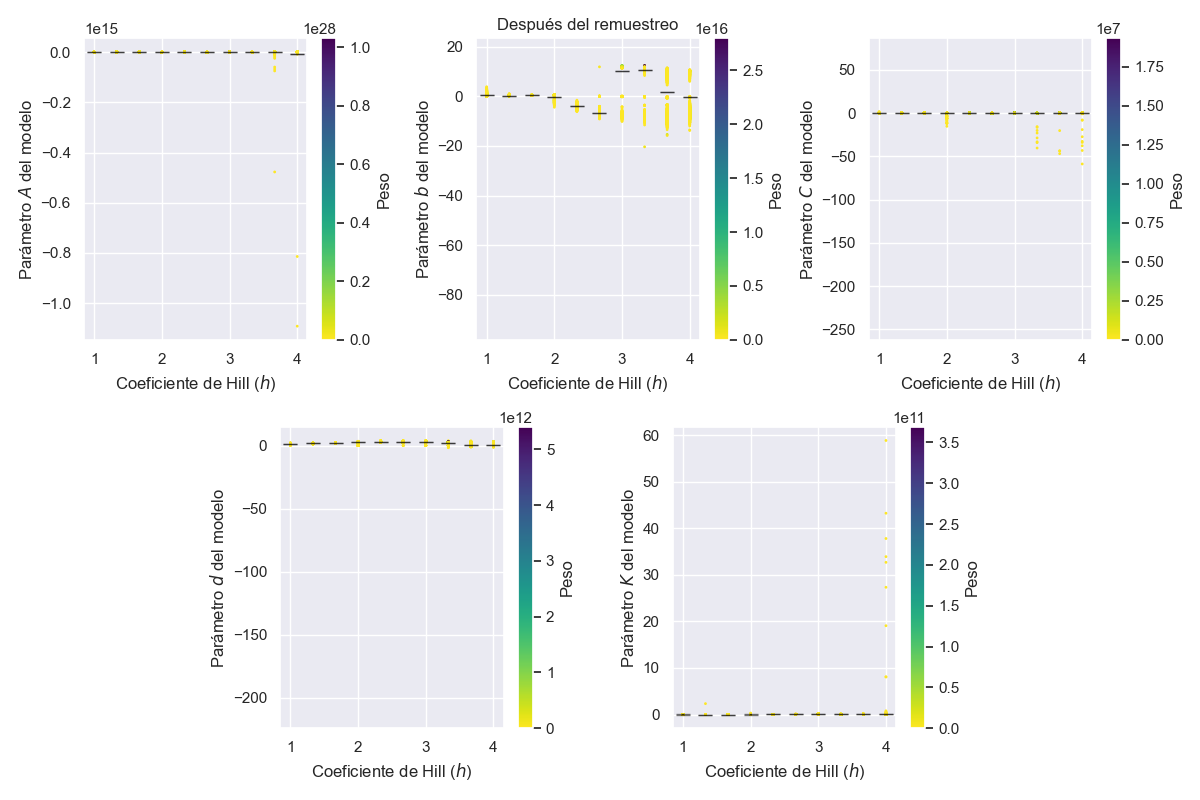

In [109]:
labels = ["A", "b", "C", "d", "K"]
plot_bootstrap(TresGlobParams, ParamsTensorTresEfc, ErrTensorTresEfc, labels, title="Ruido global en cascada represora de tres genes"+"\n"+r"$\eta_{3_g}^2=A{\eta_{1_g}^2}^{-b}+C{\eta_{2_g}^2}^{-d}+K$")

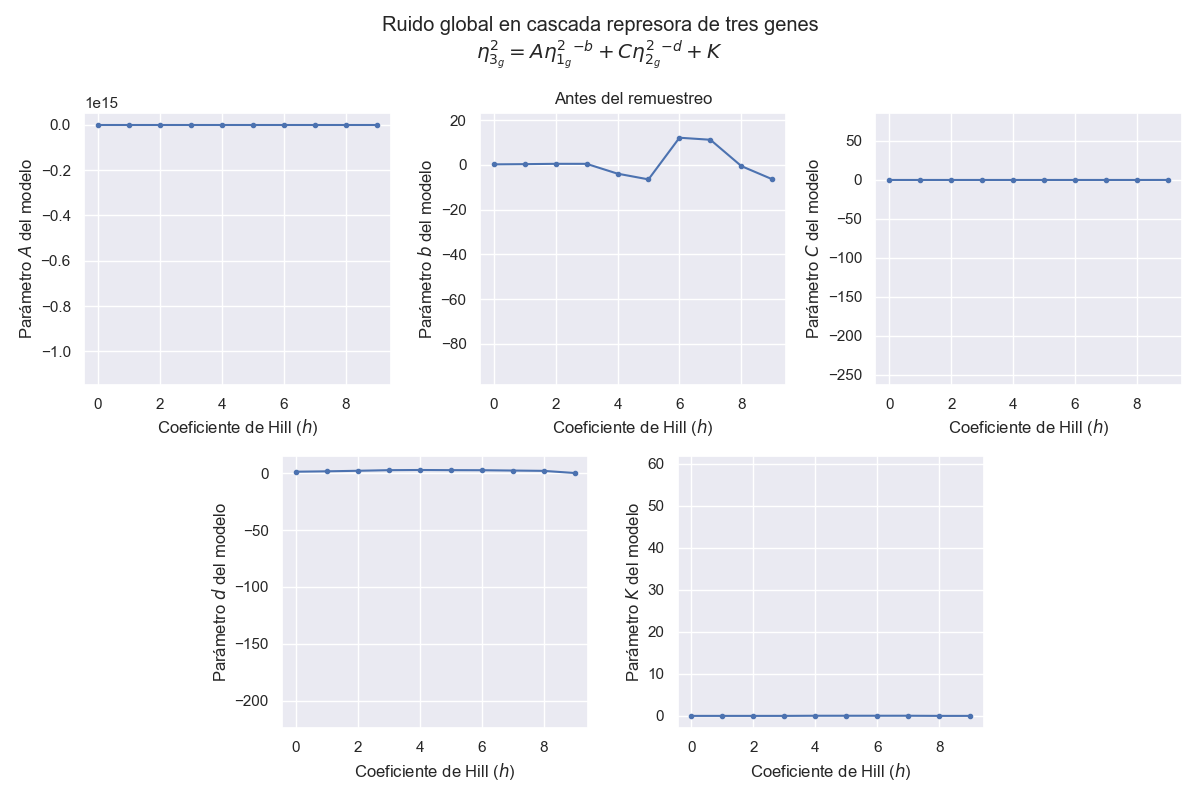

In [110]:
labels = ["A", "b", "C", "d", "K"]
plot_prebootstrap(TresGlobParams, ParamsTensorTresEfc, ErrTensorTresEfc, labels, title="Ruido global en cascada represora de tres genes"+"\n"+r"$\eta_{3_g}^2=A{\eta_{1_g}^2}^{-b}+C{\eta_{2_g}^2}^{-d}+K$")

# Export

In [ ]:
seeds_df = pd.read_csv("RepressorsDefinitiveSeeds.csv", index_col=0)
seeds_df["3 genes"] = [def_seed_int, def_seed_net]
seeds_df.to_csv("RepressorsDefinitiveSeeds.csv")

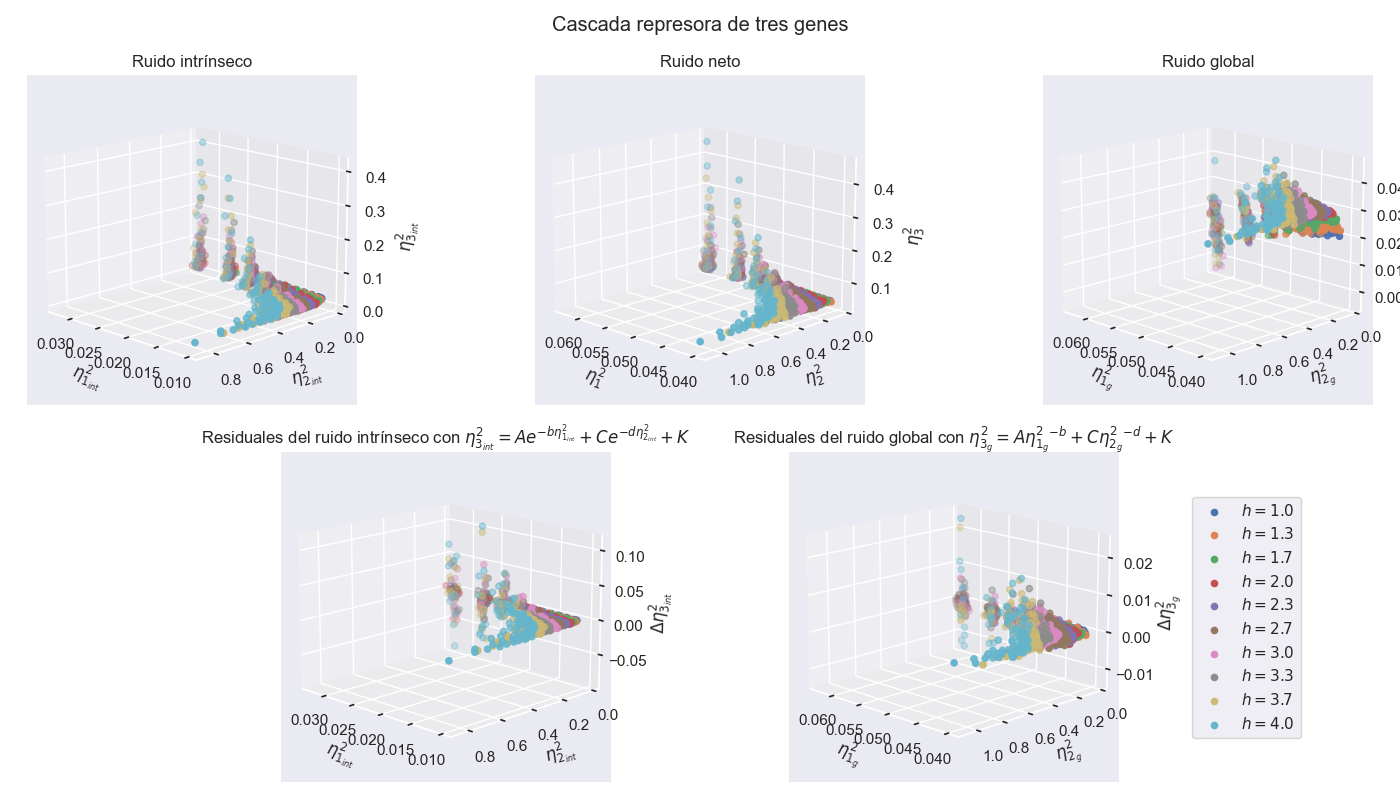

In [ ]:
plt.figure(figsize=(14,8))

ax = plt.subplot2grid((2,6), (0,0), colspan=2, projection="3d")
for h_i in h_list:
    noise1 = tres_int.loc[tres_int.h==h_i]["Protein 1"]
    noise2 = tres_int.loc[tres_int.h==h_i]["Protein 2"]
    noise3 = tres_int.loc[tres_int.h==h_i]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3, label=fr"$h={h_i:.2}$")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_{1_{int}}^2$")
    ax.set_ylabel(r"$\eta_{2_{int}}^2$")
    ax.set_zlabel(r"$\eta_{3_{int}}^2$")
    ax.set_title("Ruido intrínseco")

ax = plt.subplot2grid((2,6), (0,2), colspan=2, projection="3d")
for h_i in h_list:
    noise1 = tres_net.loc[tres_net.h==h_i]["Protein 1"]
    noise2 = tres_net.loc[tres_net.h==h_i]["Protein 2"]
    noise3 = tres_net.loc[tres_net.h==h_i]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3, label=fr"$h={h_i:.2}$")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_1^2$")
    ax.set_ylabel(r"$\eta_2^2$")
    ax.set_zlabel(r"$\eta_3^2$")
    ax.set_title("Ruido neto")

ax = plt.subplot2grid((2,6), (0,4), colspan=2, projection="3d")
for h_i in h_list:
    noise1 = tres_efc.loc[tres_efc.h==h_i]["Protein 1"]
    noise2 = tres_efc.loc[tres_efc.h==h_i]["Protein 2"]
    noise3 = tres_efc.loc[tres_efc.h==h_i]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3, label=fr"$h={h_i:.2}$")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_{1_g}^2$")
    ax.set_ylabel(r"$\eta_{2_g}^2$")
    ax.set_zlabel(r"$\eta_{3_g}^2$")
    ax.set_title("Ruido global")

ax = plt.subplot2grid((2,6), (1,1), colspan=2, projection="3d")
def model(data, A, b, C, d, K):
    x, y = data
    return A*np.exp(-b*x) + C*np.exp(-d*y) + K
for i in range(len(h_list)):
    noise1 = tres_int.loc[tres_int.h==h_list[i]]["Protein 1"]
    noise2 = tres_int.loc[tres_int.h==h_list[i]]["Protein 2"]
    noise3 = tres_int.loc[tres_int.h==h_list[i]]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3-model([noise1, noise2], *(TresIntParams[i])), label=fr"$h={h_list[i]:.2}$")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_{1_{int}}^2$")
    ax.set_ylabel(r"$\eta_{2_{int}}^2$")
    ax.set_zlabel(r"$\Delta \eta_{3_{int}}^2$")
    ax.set_title(r"Residuales del ruido intrínseco con $\eta_{3_{int}}^2=Ae^{-b\eta_{1_{int}}^2}+Ce^{-d\eta_{2_{int}}^2}+K$")

ax = plt.subplot2grid((2,6), (1,3), colspan=2, projection="3d")
def model(data, A, b, C, d, K):
    x, y = data
    return A*(x**(-b)) + C*(y**(-d)) + K
for i in range(len(h_list)):
    noise1 = tres_efc.loc[tres_efc.h==h_list[i]]["Protein 1"]
    noise2 = tres_efc.loc[tres_efc.h==h_list[i]]["Protein 2"]
    noise3 = tres_efc.loc[tres_efc.h==h_list[i]]["Protein 3"]
    
    ax.scatter(noise1, noise2, noise3-model([noise1, noise2], *(TresGlobParams[i])), label=fr"$h={h_list[i]:.2}$")
    ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
    ax.view_init(elev=15, azim=135, roll=0)
    ax.set_xlabel(r"$\eta_{1_g}^2$")
    ax.set_ylabel(r"$\eta_{2_g}^2$")
    ax.set_zlabel(r"$\Delta \eta_{3_g}^2$")
    ax.set_title(r"Residuales del ruido global con $\eta_{3_g}^2=A{\eta_{1_g}^2}^{-b}+C{\eta_{2_g}^2}^{-d}+K$")

plt.suptitle("Cascada represora de tres genes")
plt.tight_layout()
plt.savefig("GraficasParaGuardar/Simulacion/CascadaRepresoraTres.png", dpi=1000)